In [1]:
#Exercises Chapter 3

In [2]:
import numpy as np
import pandas as pd;
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
from statsmodels.stats.anova import anova_lm
from ISLP import load_data



# Exercise 8 for Auto data set #
Use the sm.OLS() function to perform a simple linear regression
with mpg as the response and horsepower as the predictor. Use
the summarize() function to print the results.

In [3]:
Auto = load_data('Auto')
Auto.columns



Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'year', 'origin'],
      dtype='object')

Create the Model Matrix

In [4]:
X = pd.DataFrame({'horsepower': Auto['horsepower']})
X = sm.add_constant(X)
print("Shape of X:", X.shape)
X[:4]

Shape of X: (392, 2)


,const,horsepower
0,1.0,130
1,1.0,165
2,1.0,150
3,1.0,150


In [5]:
y = Auto['mpg']

model = sm.OLS(y, X)
results = model.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Thu, 20 Feb 2025   Prob (F-statistic):           7.03e-81
Time:                        12:00:16   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.9359      0.717     55.660      0.000      38.525      41.347
horsepower    -0.1578      0.006    -24.489      0.000      -0.171      -0.145
==============================================================================
Omnibus:                       16.432   Durbin-Watson:                   0.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.305
Skew:                           0.492   Prob(JB):                     0.000175
Kurtosis:                       3.299   Cond. No.                         322.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Observations: There seems to be a significant relationship between horsepower and mpg. 
Its a negative relationship. And its a rather strong response, since the p value for the t-test is virtually zero.


In [6]:
new_df = pd.DataFrame({'const': [1],'horsepower': [98]})  
# important: you cant use sm.add_constant(df) if df has only one row
new_df
print("Shape of new_df:", new_df.shape)
prediction = results.get_prediction(new_df)
print(prediction)
print(prediction.summary_frame())


##dir(X)

Shape of new_df: (1, 2)
        mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
0  24.467077  0.251262      23.973079      24.961075     14.809396   

   obs_ci_upper  
0     34.124758  


Plot the response and the predictor in a new set of axes ax. Use
the ax.axline() method or the abline() function defined in the
lab to display the least squares regression line.

In [7]:
def abline(ax, b, m, *args, **kwargs):
    "Add a line with slope m and intercept b to ax"
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim, ylim, *args, **kwargs)

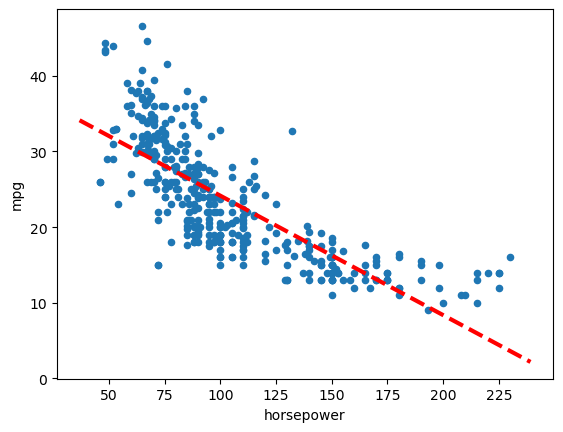

In [8]:
ax = Auto.plot.scatter('horsepower', 'mpg')
abline(ax,
       results.params.iloc[0],
       results.params.iloc[1],
       'r--',
       linewidth=3)

Plot the response and the predictor in a new set of axes ax. Use
the ax.axline() method or the abline() function defined in the
lab to display the least squares regression line.

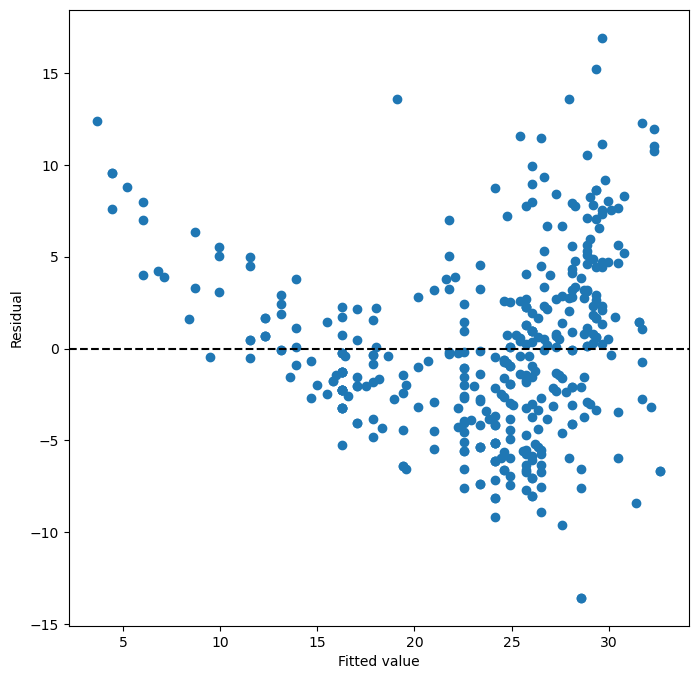

In [9]:
ax = subplots(figsize=(8,8))[1]
ax.scatter(results.fittedvalues, results.resid)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--');

The residual plot suggests non-linearity as there is a clear pattern of Residuals 
dependent on the fitted values. Also we seem to have two candidates for potential outliers.


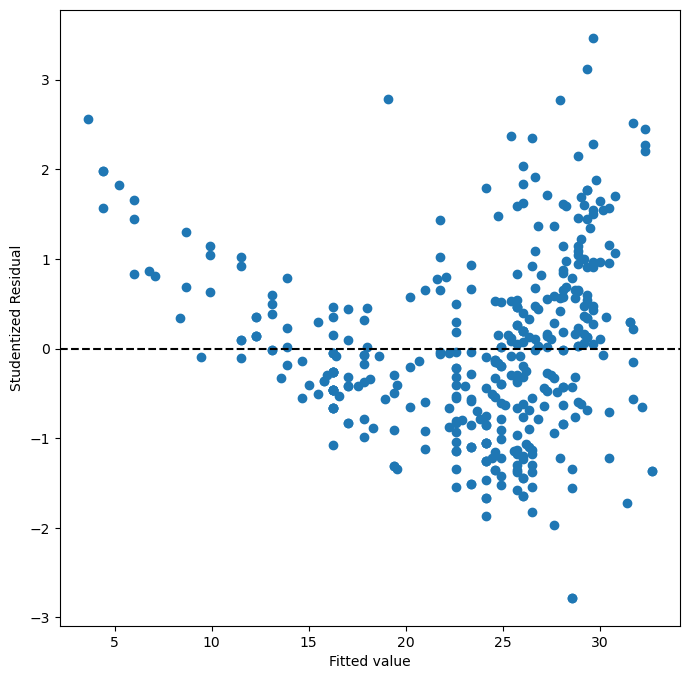

In [10]:
infl = results.get_influence()

leverage = infl.hat_matrix_diag

residuals = results.resid

mse = np.mean(residuals ** 2)

# Studentized residuals formula
studentized_residuals = residuals / np.sqrt(mse * (1 - leverage))

ax = subplots(figsize=(8,8))[1]
ax.scatter(results.fittedvalues, studentized_residuals)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Studentized Residual')
ax.axhline(0, c='k', ls='--');

THe studentized residual plot shows that my assumption of two outliers was almost right.
There seems to be one more value that should be considered and outlier.

     horsepower   mpg
5           198  15.0
6           220  14.0
7           215  14.0
8           225  14.0
9           190  15.0
13          225  14.0
25          215  10.0
26          200  10.0
27          210  11.0
28          193   9.0
66          208  11.0
69          190  13.0
89          198  12.0
93          215  13.0
94          225  12.0
115         230  16.0
229         190  15.5
0.00510204081632653


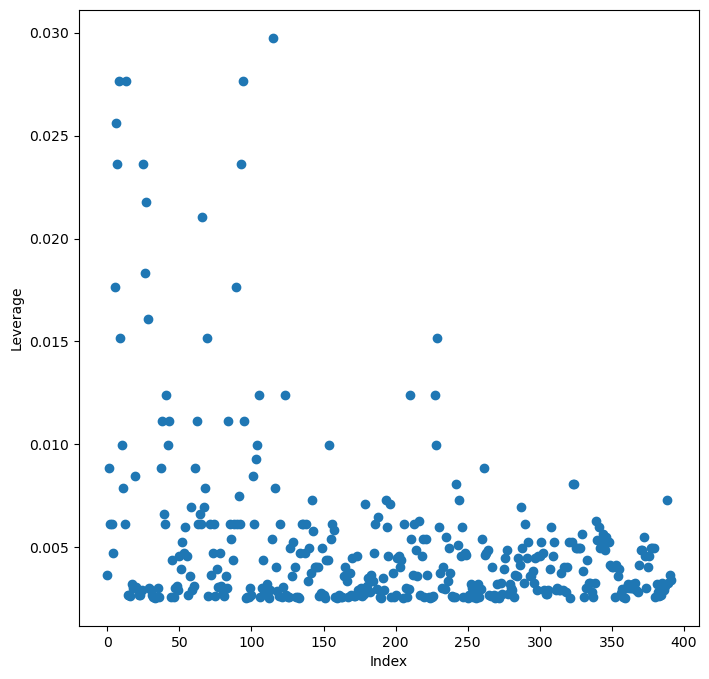

In [11]:
infl = results.get_influence()
ax = subplots(figsize=(8,8))[1]
ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
print(Auto.iloc[np.where(infl.hat_matrix_diag > 0.015)][['horsepower', 'mpg']])
print(2/Auto.shape[0])


The average leverage statistic equals .0051 
Therefore I would consider all points above 0.015 as high leverage. Still I would not necessarily exclude
them from the dataset, as they seem to be aligned with some non-linear (quadratic?) regression line

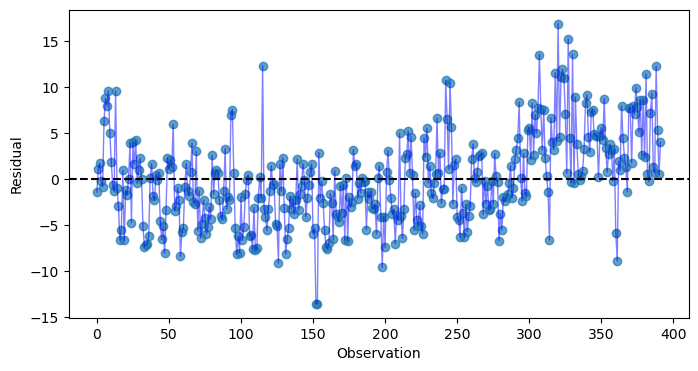

In [12]:
indices = Auto.index
residuals = results.resid
ax = subplots(figsize=(8,4))[1]
ax.scatter(indices, residuals, alpha=0.7, label="Residuals")
ax.plot(indices, residuals, color='blue', alpha=0.5, linestyle='-', linewidth=1)
ax.set_xlabel('Observation')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--');

This does not look like there is a correlation between error terms

# Exercise 9 - Multiple Linear Regression

- Produce a scatterplot matrix for all variables

array([[<Axes: xlabel='mpg', ylabel='mpg'>,
        <Axes: xlabel='cylinders', ylabel='mpg'>,
        <Axes: xlabel='displacement', ylabel='mpg'>,
        <Axes: xlabel='horsepower', ylabel='mpg'>,
        <Axes: xlabel='weight', ylabel='mpg'>,
        <Axes: xlabel='acceleration', ylabel='mpg'>,
        <Axes: xlabel='year', ylabel='mpg'>,
        <Axes: xlabel='origin', ylabel='mpg'>],
       [<Axes: xlabel='mpg', ylabel='cylinders'>,
        <Axes: xlabel='cylinders', ylabel='cylinders'>,
        <Axes: xlabel='displacement', ylabel='cylinders'>,
        <Axes: xlabel='horsepower', ylabel='cylinders'>,
        <Axes: xlabel='weight', ylabel='cylinders'>,
        <Axes: xlabel='acceleration', ylabel='cylinders'>,
        <Axes: xlabel='year', ylabel='cylinders'>,
        <Axes: xlabel='origin', ylabel='cylinders'>],
       [<Axes: xlabel='mpg', ylabel='displacement'>,
        <Axes: xlabel='cylinders', ylabel='displacement'>,
        <Axes: xlabel='displacement', ylabel='displacement

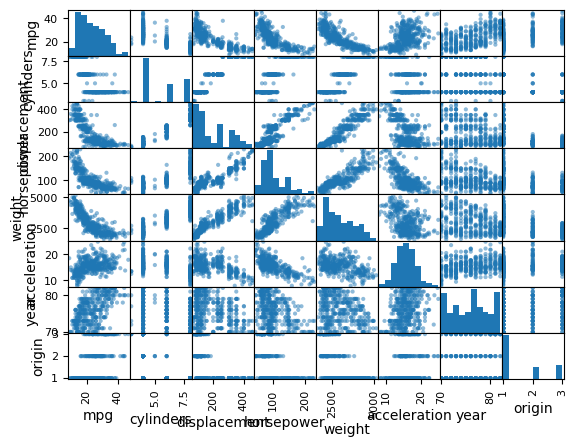

In [13]:
Auto = pd.read_csv('Auto.csv',na_values=['?'])
pd.plotting.scatter_matrix(Auto)

Compute the matrix of correlations

In [14]:
Auto_dna = Auto.dropna()
Auto_new = Auto_dna.set_index('name')
print(Auto_new.corr())


                   mpg  cylinders  displacement  horsepower    weight  \
mpg           1.000000  -0.777618     -0.805127   -0.778427 -0.832244   
cylinders    -0.777618   1.000000      0.950823    0.842983  0.897527   
displacement -0.805127   0.950823      1.000000    0.897257  0.932994   
horsepower   -0.778427   0.842983      0.897257    1.000000  0.864538   
weight       -0.832244   0.897527      0.932994    0.864538  1.000000   
acceleration  0.423329  -0.504683     -0.543800   -0.689196 -0.416839   
year          0.580541  -0.345647     -0.369855   -0.416361 -0.309120   
origin        0.565209  -0.568932     -0.614535   -0.455171 -0.585005   

              acceleration      year    origin  
mpg               0.423329  0.580541  0.565209  
cylinders        -0.504683 -0.345647 -0.568932  
displacement     -0.543800 -0.369855 -0.614535  
horsepower       -0.689196 -0.416361 -0.455171  
weight           -0.416839 -0.309120 -0.585005  
acceleration      1.000000  0.290316  0.212746  

Perform a multiple linear regression with mpg as the response and all other variabels except name as predictors

In [15]:
X = Auto_new.drop(['mpg'],axis=1)
y = Auto_new['mpg']
X = sm.add_constant(X) 
est = sm.OLS(y, X).fit() 
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     252.4
Date:                Thu, 20 Feb 2025   Prob (F-statistic):          2.04e-139
Time:                        12:00:20   Log-Likelihood:                -1023.5
No. Observations:                 392   AIC:                             2063.
Df Residuals:                     384   BIC:                             2095.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -17.2184      4.644     -3.707      0.000     -26.350      -8.087
cylinders       -0.4934      0.323     -1.526      0.128      -1.129       0.142
displacement     0.0199      0.008      2.647      0.008       0.005       0.035
horsepower      -0.0170      0.014     -1.230      0.220      -0.044       0.010
weight          -0.0065      0.001     -9.929      0.000      -0.008      -0.005
acceleration     0.0806      0.099      0.815      0.415      -0.114       0.275
year             0.7508      0.051     14.729      0.000       0.651       0.851
origin           1.4261      0.278      5.127      0.000       0.879       1.973
==============================================================================
Omnibus:                       31.906   Durbin-Watson:                   1.309
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.100
Skew:                           0.529   Prob(JB):                     2.95e-12
Kurtosis:                       4.460   Cond. No.                     8.59e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.59e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

i) is there a relationship between the predictors and the response?

In [16]:
predictors = Auto.columns.drop(['name', 'mpg'])
formul = ' + '.join(predictors)

est2 = smf.ols(f'mpg ~ {formul}', data=Auto).fit()

table = sm.stats.anova_lm(est2) 
print(table)

                 df        sum_sq       mean_sq            F         PR(>F)
cylinders       1.0  14403.083079  14403.083079  1300.683788  2.319511e-125
displacement    1.0   1073.344025   1073.344025    96.929329   1.530906e-20
horsepower      1.0    403.408069    403.408069    36.430140   3.731128e-09
weight          1.0    975.724953    975.724953    88.113748   5.544461e-19
acceleration    1.0      0.966071      0.966071     0.087242   7.678728e-01
year            1.0   2419.120249   2419.120249   218.460900   1.875281e-39
origin          1.0    291.134494    291.134494    26.291171   4.665681e-07
Residual      384.0   4252.212530     11.073470          NaN            NaN


The F value indicates the significance of adding the predictor to the model. Therefore 
only acceleration seems to have no relationship with mpg

The coefficient for the year variable suggests, that if we keep all other predictors constant, 
that every 9 months increase the mpg increases one unit

Produce some of diagnostic plots of the linear regression fit as
described in the lab. Comment on any problems you see with the
fit. Do the residual plots suggest any unusually large outliers?
Does the leverage plot identify any observations with unusually
high leverage?

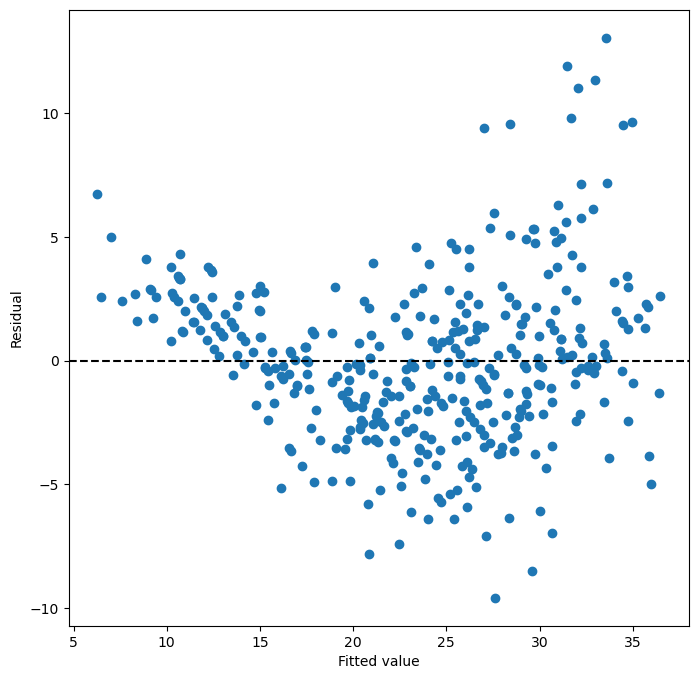

In [17]:
ax = subplots(figsize=(8,8))[1]
ax.scatter(est.fittedvalues, est.resid)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--');

This indicates nonlinearity

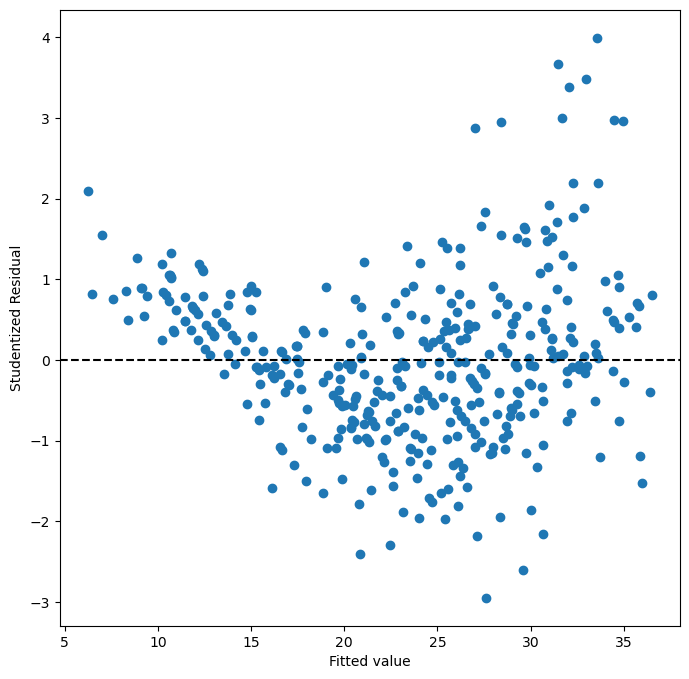

In [18]:
infl = est.get_influence()

leverage = infl.hat_matrix_diag

residuals = est.resid

mse = np.mean(residuals ** 2)

# Studentized residuals formula
studentized_residuals = residuals / np.sqrt(mse * (1 - leverage))

ax = subplots(figsize=(8,8))[1]
ax.scatter(est.fittedvalues, studentized_residuals)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Studentized Residual')
ax.axhline(0, c='k', ls='--');

- Fit some models with interactions

In [19]:
def hyperbola(x):
    return 1/x

def squared(x):
    return x ** 2

predictors = Auto.columns.drop(['name', 'mpg', 'cylinders'])
formul = ' + '.join(predictors)
formul = formul + '+ hyperbola(horsepower) + squared(acceleration) + weight*displacement + year * origin + squared(year)'

est3 = smf.ols(f'mpg ~ {formul}', data=Auto).fit()

print(est3.summary())

table = sm.stats.anova_lm(est3,typ=3) 
print(table)

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     253.1
Date:                Thu, 20 Feb 2025   Prob (F-statistic):          2.59e-167
Time:                        12:00:20   Log-Likelihood:                -945.75
No. Observations:                 392   AIC:                             1915.
Df Residuals:                     380   BIC:                             1963.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               382.52


# Exercise 10

In [20]:
from ISLP import load_data
Carseats = load_data('Carseats')
Carseats.columns
df_cs = pd.DataFrame(Carseats)
print(df_cs.head())

   Sales  CompPrice  Income  Advertising  Population  Price ShelveLoc  Age  \
0   9.50        138      73           11         276    120       Bad   42   
1  11.22        111      48           16         260     83      Good   65   
2  10.06        113      35           10         269     80    Medium   59   
3   7.40        117     100            4         466     97    Medium   55   
4   4.15        141      64            3         340    128       Bad   38   

   Education Urban   US  
0         17   Yes  Yes  
1         10   Yes  Yes  
2         12   Yes  Yes  
3         14   Yes  Yes  
4         13   Yes   No  


In [21]:


est4 = smf.ols(f'Sales ~ Price + Urban + US', data=df_cs).fit()

print(est4.summary())

table = sm.stats.anova_lm(est4,typ=3) 
print(table)

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     41.52
Date:                Thu, 20 Feb 2025   Prob (F-statistic):           2.39e-23
Time:                        12:00:25   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1863.
Df Residuals:                     396   BIC:                             1879.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       13.0435      0.651     20.036   

In [22]:
est5 = smf.ols(f'Sales ~ Price + US', data=df_cs).fit()

print(est5.summary())

table = sm.stats.anova_lm(est5,typ=3) 
print(table)

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     62.43
Date:                Thu, 20 Feb 2025   Prob (F-statistic):           2.66e-24
Time:                        12:00:25   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1861.
Df Residuals:                     397   BIC:                             1873.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.0308      0.631     20.652      0.0

In [23]:
est5.conf_int()


,0,1
Intercept,11.79032,14.271265
US[T.Yes],0.69152,1.707766
Price,-0.06476,-0.044195


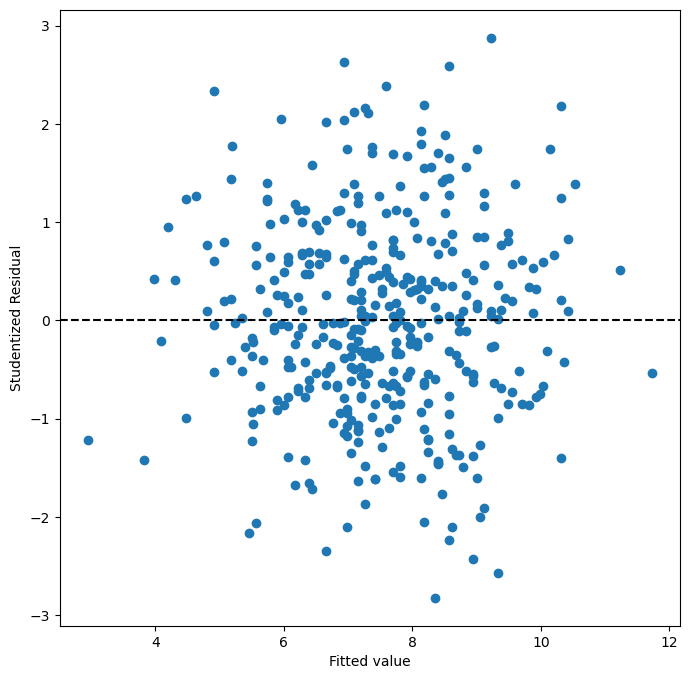

In [24]:
model = est5

infl = model.get_influence()

leverage = infl.hat_matrix_diag

residuals = model.resid

mse = np.mean(residuals ** 2)

# Studentized residuals formula
studentized_residuals = residuals / np.sqrt(mse * (1 - leverage))

ax = subplots(figsize=(8,8))[1]
ax.scatter(model.fittedvalues, studentized_residuals)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Studentized Residual')
ax.axhline(0, c='k', ls='--');

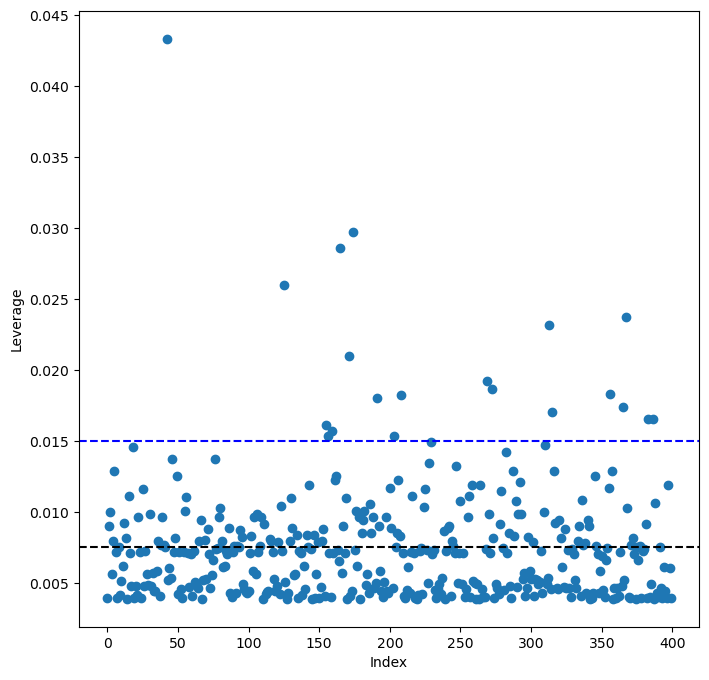

In [25]:
model = est5
infl = model.get_influence()
ax = subplots(figsize=(8,8))[1]
ax.scatter(np.arange(df_cs.shape[0]), infl.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
mean = 3/df_cs.shape[0]
threshold = 2 * mean
ax.axhline(mean, c='k', ls='--');
ax.axhline(threshold, c='b', ls='--');



In [26]:
infl.hat_matrix_diag
high_leverage_points = np.where(leverage > threshold)[0]
print("High leverage points:", high_leverage_points)

# Remove high leverage points
cleaned_cs = df_cs.drop(index=high_leverage_points)

print("Cleaned Data:\n", cleaned_cs)

est6 = smf.ols(f'Sales ~ Price + US', data=cleaned_cs).fit()

print(est6.summary())

table = sm.stats.anova_lm(est6,typ=3) 
print(table)

High leverage points: [ 42 125 155 156 159 165 171 174 191 203 208 269 272 313 315 356 365 367
 383 386]
Cleaned Data:
      Sales  CompPrice  Income  Advertising  Population  Price ShelveLoc  Age  \
0     9.50        138      73           11         276    120       Bad   42   
1    11.22        111      48           16         260     83      Good   65   
2    10.06        113      35           10         269     80    Medium   59   
3     7.40        117     100            4         466     97    Medium   55   
4     4.15        141      64            3         340    128       Bad   38   
..     ...        ...     ...          ...         ...    ...       ...  ...   
395  12.57        138     108           17         203    128      Good   33   
396   6.14        139      23            3          37    120    Medium   55   
397   7.41        162      26           12         368    159    Medium   40   
398   5.94        100      79            7         284     95       Bad   50   


# Exercise 11 - Simple Linear Regression without an Intercept




In [27]:
rng = np.random.default_rng(1)
x = rng.normal(size =100)
y = 2 * x + rng.normal(size =100)

In [28]:
est7 = sm.OLS(x,y).fit()
est7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.743
Model:                            OLS   Adj. R-squared (uncentered):              0.740
Method:                 Least Squares   F-statistic:                              285.6
Date:                Thu, 20 Feb 2025   Prob (F-statistic):                    6.23e-31
Time:                        12:00:26   Log-Likelihood:                         -58.349
No. Observations:                 100   AIC:                                      118.7
Df Residuals:                      99   BIC:                                      121.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3757      0.022     16.898      0.000       0.332       0.420
==============================================================================
Omnibus:                       13.156   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               22.596
Skew:                          -0.528   Prob(JB):                     1.24e-05
Kurtosis:                       5.075   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
est7 = sm.OLS(y,x).fit()
est7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.743
Model:                            OLS   Adj. R-squared (uncentered):              0.740
Method:                 Least Squares   F-statistic:                              285.6
Date:                Thu, 20 Feb 2025   Prob (F-statistic):                    6.23e-31
Time:                        12:00:26   Log-Likelihood:                         -141.35
No. Observations:                 100   AIC:                                      284.7
Df Residuals:                      99   BIC:                                      287.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.9762      0.117     16.898      0.000       1.744       2.208
==============================================================================
Omnibus:                        1.376   Durbin-Watson:                   2.184
Prob(Omnibus):                  0.503   Jarque-Bera (JB):                0.847
Skew:                           0.121   Prob(JB):                        0.655
Kurtosis:                       3.381   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Exercise 12
- Generate an example in Python with n = 100 observations in
which the coefficient estimate for the regression of X onto Y
is different from the coefficient estimate for the regression of Y
onto X.
- Generate an example in Python with n = 100 observations in
which the coefficient estimate for the regression of X onto Y is
the same as the coefficient estimate for the regression of Y onto
X.

In [30]:
rng = np.random.default_rng(1)
x = rng.normal(size =100)
y = rng.normal(size =100)

In [31]:
est9 = sm.OLS(x,y).fit()
print(est9.summary())
est10 = sm.OLS(y,y).fit()
print(est10.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):             -0.010
Method:                 Least Squares   F-statistic:                            0.04127
Date:                Thu, 20 Feb 2025   Prob (F-statistic):                       0.839
Time:                        12:00:26   Log-Likelihood:                         -126.18
No. Observations:                 100   AIC:                                      254.4
Df Residuals:                      99   BIC:                                      257.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

E:\dev\.conda\envs\islp\Lib\site-packages\statsmodels\regression\linear_model.py:1871: RuntimeWarning: divide by zero encountered in scalar divide
  return self.mse_model/self.mse_resid
E:\dev\.conda\envs\islp\Lib\site-packages\statsmodels\regression\linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
E:\dev\.conda\envs\islp\Lib\site-packages\statsmodels\stats\stattools.py:50: RuntimeWarning: invalid value encountered in scalar divide
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)


# Exercise 13


In [32]:
rng = np.random.default_rng(1)
x = rng.normal(0,1,100)
eps = rng.normal(0,0.25,100)
beta_0 = -1
beta_1 = 0.5
y = beta_0 + beta_1*x + eps

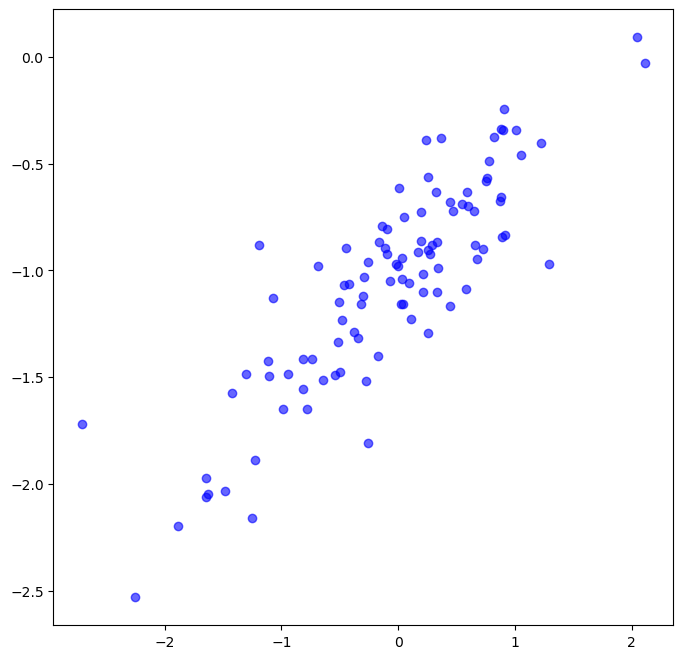

In [33]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x, y, label="Sample Data", color="blue", alpha=0.6)

In [34]:
x_wc = sm.add_constant(x)
est11 = sm.OLS(y,x_wc).fit()
est11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     280.0
Date:                Thu, 20 Feb 2025   Prob (F-statistic):           1.74e-30
Time:                        12:00:26   Log-Likelihood:                -2.4306
No. Observations:                 100   AIC:                             8.861
Df Residuals:                      98   BIC:                             14.07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0190      0.025    -40.537      0.000      -1.069      -0.969
x1             0.4921      0.029     16.734      0.000       0.434       0.551
==============================================================================
Omnibus:                        1.277   Durbin-Watson:                   2.198
Prob(Omnibus):                  0.528   Jarque-Bera (JB):                0.759
Skew:                           0.114   Prob(JB):                        0.684
Kurtosis:                       3.361   Cond. No.                         1.20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- Create a scatterplot displaying the relationship between x and
y. Comment on what you observe.
- Fit a least squares linear model to predict y using x. Comment
on the model obtained. How do ˆ β0 and ˆ β1 compare to β0 and
β1?
- Display the least squares line on the scatterplot obtained in (d).
Draw the population regression line on the plot, in a different
color. Use the legend() method of the axes to create an appropriate
legend.

(d) Create a scatterplot displaying the relationship between x and
y. Comment on what you observe.
(e) Fit a least squares linear model to predict y using x. Comment
on the model obtained. How do ˆ β0 and ˆ β1 compare to β0 and
β1?
(f) Display the least squares line on the scatterplot obtained in (d).
Draw the population regression line on the plot, in a different
color. Use the legend() method of the axes to create an appropriate
legend.
(g) Now fit a polynomial

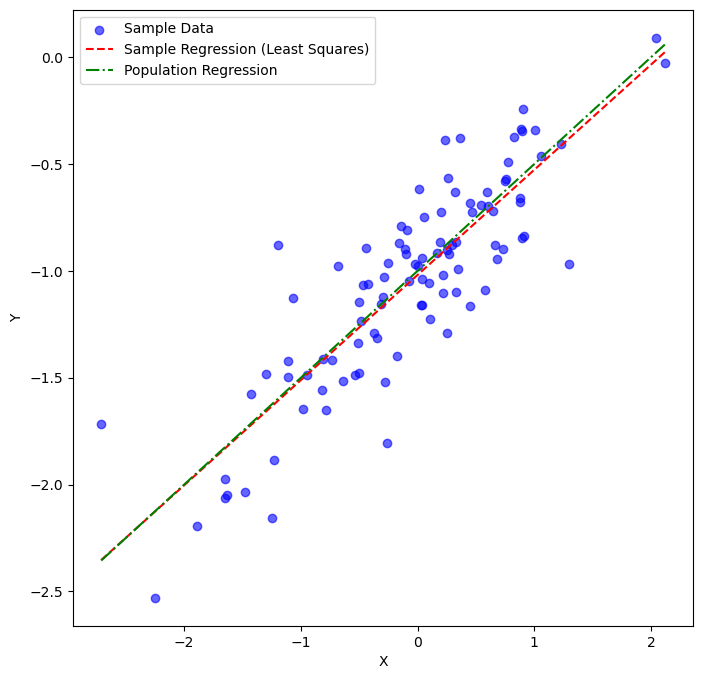

In [35]:
beta_hat_0, beta_hat_1 = est11.params

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x, y, label="Sample Data", color="blue", alpha=0.6)

x_range = np.linspace(min(x), max(x), 100)
ax.plot(x_range, beta_hat_0 + beta_hat_1 * x_range, label="Sample Regression (Least Squares)", color="red", linestyle="--")

# Plot the population regression line
ax.plot(x_range, beta_0 + beta_1*x_range, label="Population Regression", color="green", linestyle="-.")

# Labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
plt.show()

- Now fit a polynomial regression model that predicts y using x
and x2. Is there evidence that the quadratic term improves the
model fit? Explain your answer.


In [36]:
X_poly = np.column_stack((x, x**2))
X_poly = sm.add_constant(X_poly)
est12 = sm.OLS(y, X_poly).fit()
print(est12.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     138.6
Date:                Thu, 20 Feb 2025   Prob (F-statistic):           3.66e-29
Time:                        12:00:26   Log-Likelihood:                -2.4293
No. Observations:                 100   AIC:                             10.86
Df Residuals:                      97   BIC:                             18.67
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0182      0.030    -34.186      0.0

Answer: Those results show that a polynomial Model does not increase the fit of the model. Both the r-squared and the t-value for the x**2 column suggest that. The difference in f-value is simply explained by the change in df with a relatively high n value compared to numbers of predictors p

Task: Repeat the steps after modifying the data generation process in
such a way that there is less noise in the data. The model
should remain the same. You can do this by decreasing the variance
of the normal distribution used to generate the error term
ϵ in. Describe your results.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     1784.
Date:                Thu, 20 Feb 2025   Prob (F-statistic):           1.08e-64
Time:                        12:00:26   Log-Likelihood:                 89.198
No. Observations:                 100   AIC:                            -174.4
Df Residuals:                      98   BIC:                            -169.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0076      0.010   -100.209      0.0

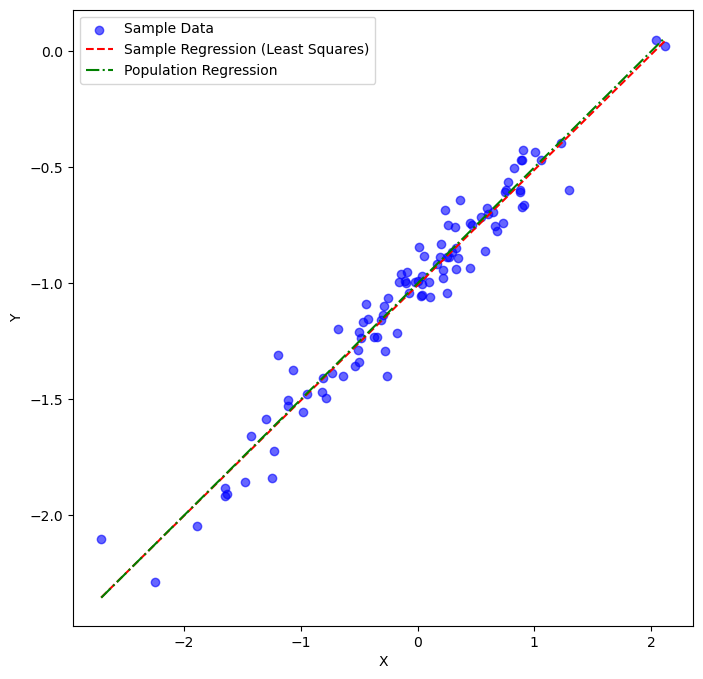

In [37]:
rng = np.random.default_rng(1)
x = rng.normal(0,1,100)
eps = rng.normal(0,0.1,100)
beta_0 = -1
beta_1 = 0.5
y = beta_0 + beta_1*x + eps

x_wc = sm.add_constant(x)
est11 = sm.OLS(y,x_wc).fit()
print(est11.summary())

beta_hat_0, beta_hat_1 = est11.params

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x, y, label="Sample Data", color="blue", alpha=0.6)

x_range = np.linspace(min(x), max(x), 100)
ax.plot(x_range, beta_hat_0 + beta_hat_1 * x_range, label="Sample Regression (Least Squares)", color="red", linestyle="--")

# Plot the population regression line
ax.plot(x_range, beta_0 + beta_1*x_range, label="Population Regression", color="green", linestyle="-.")

# Labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
plt.show()

### Answer 

--- 

As expected now the linear model is an even better fit, as the SSE has further decreased (higher SSR, closer to SST), therefore the R-squared value is even closer to 1. There is slightly improved accuracy of the estimate for the coefficient and intercept. And even more importantly the t value has even more increased. As has the F Statistic (which in this case of simple linear regression is simply the square of the t-statistic)

### Task

---
Repeat the steps after modifying the data generation process in
such a way that there is more noise in the data. The model should remain the same. You can do this by increasing
the variance of the normal distribution used to generate the
error term ϵ i. Describe your results.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     67.79
Date:                Thu, 20 Feb 2025   Prob (F-statistic):           8.04e-13
Time:                        12:00:27   Log-Likelihood:                -71.745
No. Observations:                 100   AIC:                             147.5
Df Residuals:                      98   BIC:                             152.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0380      0.050    -20.647      0.0

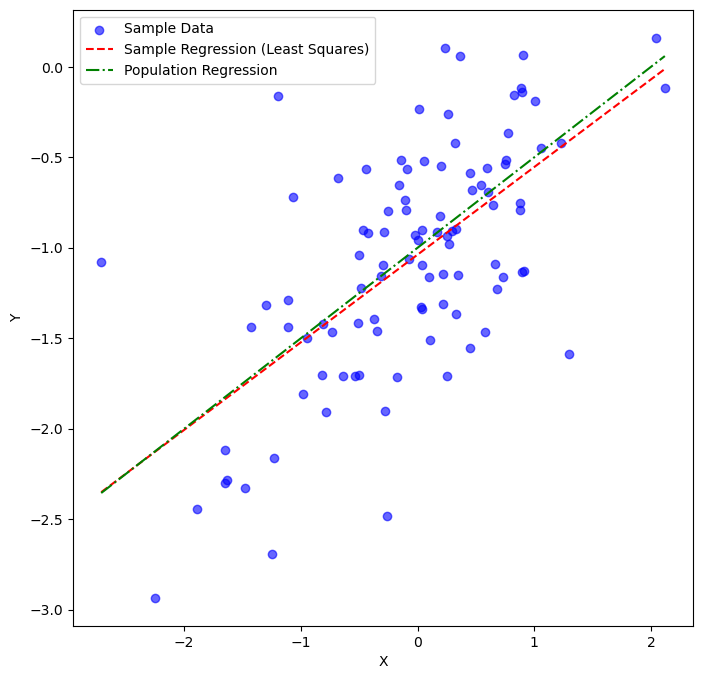

In [38]:
rng = np.random.default_rng(1)
x = rng.normal(0,1,100)
eps = rng.normal(0,0.5,100)
beta_0 = -1
beta_1 = 0.5
y = beta_0 + beta_1*x + eps

x_wc = sm.add_constant(x)
est11 = sm.OLS(y,x_wc).fit()
print(est11.summary())

beta_hat_0, beta_hat_1 = est11.params

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x, y, label="Sample Data", color="blue", alpha=0.6)

x_range = np.linspace(min(x), max(x), 100)
ax.plot(x_range, beta_hat_0 + beta_hat_1 * x_range, label="Sample Regression (Least Squares)", color="red", linestyle="--")

# Plot the population regression line
ax.plot(x_range, beta_0 + beta_1*x_range, label="Population Regression", color="green", linestyle="-.")

# Labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
plt.show()

### Answer 

--- 

As expected now the linear model is worse fit, as the SSE has further decreased (lower SSR, even smaller from SST), therefore the R-squared value is moving further away from 1. There is slightly decreased accuracy of the estimate for the coefficient and intercept. And even more importantly the t value has even more decreased. As has the F Statistic (which in this case of simple linear regression is simply the square of the t-statistic)

### Question

---

What are the confidence intervals for β0 and β1 based on the
original data set, the noisier data set, and the less noisy data
set? Comment on your results.

### Answer

---
| Var | Coeff | 0.025 - 0.975 |
| --- | --- | -------- |
| 0.25 | β0 |	-1.069 - -0.969 |
|  | β1 | 0.434 - 0.551 |
| 0.1 | β0 | -1.028   -   -0.988 |
| | β1 | 0.474   -    0.520 |
| 0.5 | β0 | -1.138   -   -0.938 |
| | β1 | 0.368    -   0.601 |

As to be expected the CI get smaller with smaller variance

# Exercise 14

In [39]:
rng = np.random.default_rng (10)
x1 = rng.uniform(0, 1, size =100)
x2 = 0.5 * x1 + rng.normal(size =100) / 10
y = 2 + 2 * x1 + 0.3 * x2 + rng.normal(size =100)

### Task 

---

What is the correlation between x1 and x2? Create a scatterplot
displaying the relationship between the variables.

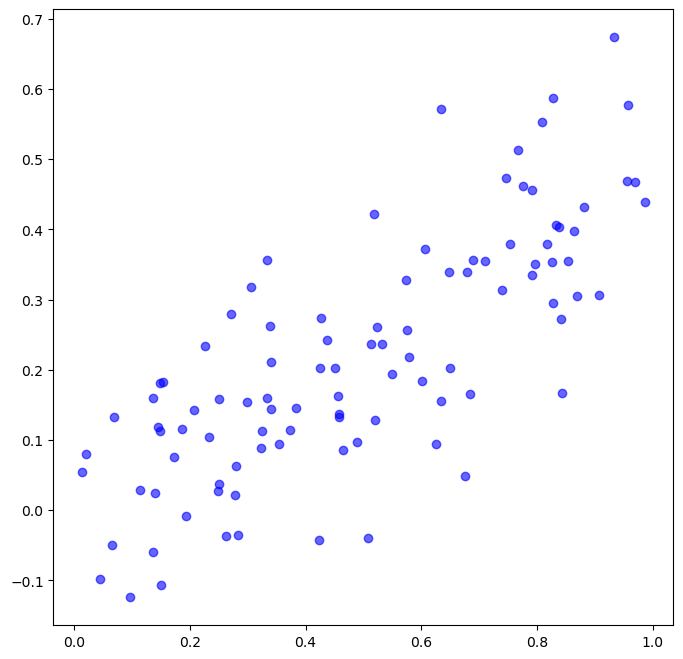

In [40]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x1, x2, label="The two predictors", color="blue", alpha=0.6)

### Answer

---
Visually this suggest a collinear relationship between x1 and x2

# Task 

---

Using this data, fit a least squares regression to predict y using
x1 and x2. Describe the results obtained. What are ˆ β0, ˆ β1, and
ˆ β2? How do these relate to the true β0, β1, and β2? Can you
reject the null hypothesis H0 : β1 = 0? How about the null
hypothesis H0 : β2 = 0?

In [41]:
X = np.column_stack((x1, x2))
X = sm.add_constant(X) 

est = sm.OLS(y,X).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     19.89
Date:                Thu, 20 Feb 2025   Prob (F-statistic):           5.76e-08
Time:                        12:00:27   Log-Likelihood:                -130.62
No. Observations:                 100   AIC:                             267.2
Df Residuals:                      97   BIC:                             275.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9579      0.190     10.319      0.000       1.581       2.334
x1             1.6154      0.527      3.065      0.003       0.569       2.661
x2             0.9428      0.831      1.134      0.259      -0.707       2.592
==============================================================================
Omnibus:                        0.051   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.975   Jarque-Bera (JB):                0.041
Skew:                          -0.036   Prob(JB):                        0.979
Kurtosis:                       2.931   Cond. No.                         11.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Answer

---
This is not a very good model even though it has significance (f-value). The t-values suggest though that we only can reject H0 : β1 = 0. This is not surprising since the real β2 value is quite close to zero (meaning it has only a weak relationship). With increased n though, we might also be able to reject H0 : β2 = 0

### Task

---
- Now fit a least squares regression to predict y using only x1.
Comment on your results. Can you reject the null hypothesis
H0 : β1 = 0?
- Now fit a least squares regression to predict y using only x2.
Comment on your results. Can you reject the null hypothesis
H0 : β1 = 0?
- Do the results obtained in (c)–(e) contradict each other? Explain
your answer.

In [42]:
est = sm.OLS(y,sm.add_constant(x1)).fit()
print(est.summary())

est = sm.OLS(y,sm.add_constant(x2)).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     38.39
Date:                Thu, 20 Feb 2025   Prob (F-statistic):           1.37e-08
Time:                        12:00:27   Log-Likelihood:                -131.28
No. Observations:                 100   AIC:                             266.6
Df Residuals:                      98   BIC:                             271.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9371      0.189     10.242      0.0

### Answer 

---
If we only fit y to the single predictor each, both coefficients show as significant and we can therefore reject both Nullhypotheses. The fact that β2 "vanishes" in the multiple linear regression model, can be explained by the collinearity of x1 and x2

### Task

---
Suppose we obtain one additional observation, which was unfortunately
mismeasured. We use the function np.concatenate() to np.concaadd
this additional observation to each of x1, x2 and y.

Re-fit the linear models from the earlier models using this new data. What
effect does this new observation have on the each of the models?
In each model, is this observation an outlier? A high-leverage
point? Both? Explain your answers.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     19.89
Date:                Thu, 20 Feb 2025   Prob (F-statistic):           5.76e-08
Time:                        12:00:27   Log-Likelihood:                -130.62
No. Observations:                 100   AIC:                             267.2
Df Residuals:                      97   BIC:                             275.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9579      0.190     10.319      0.0

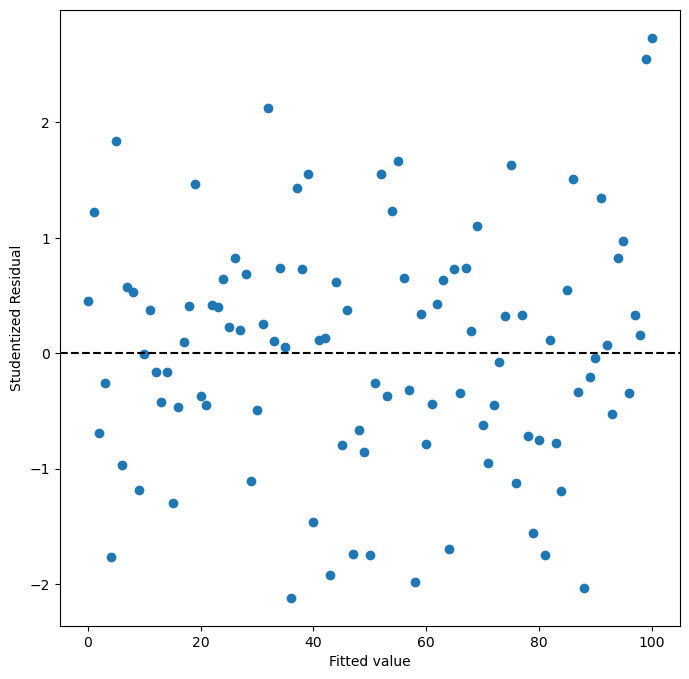

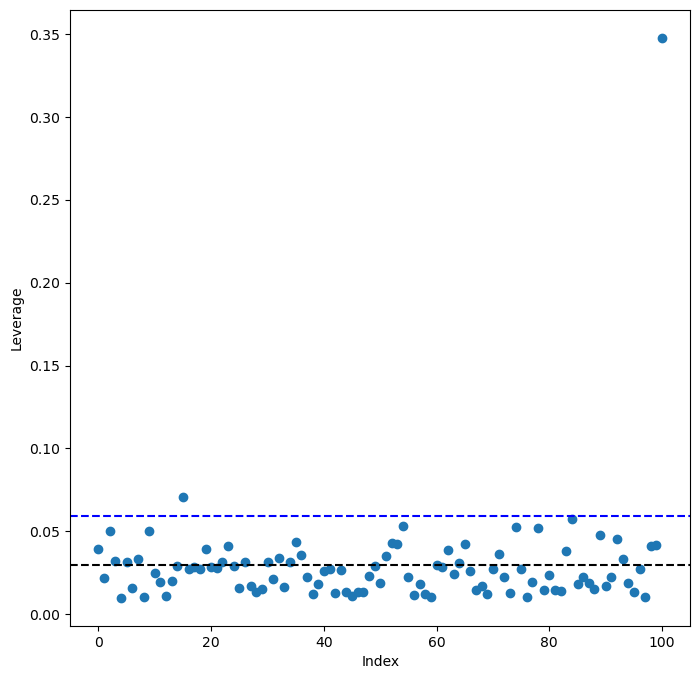

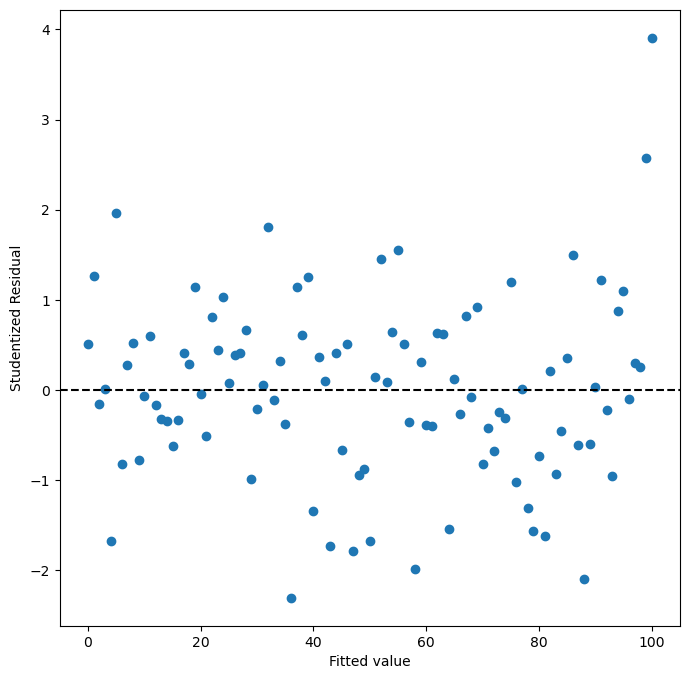

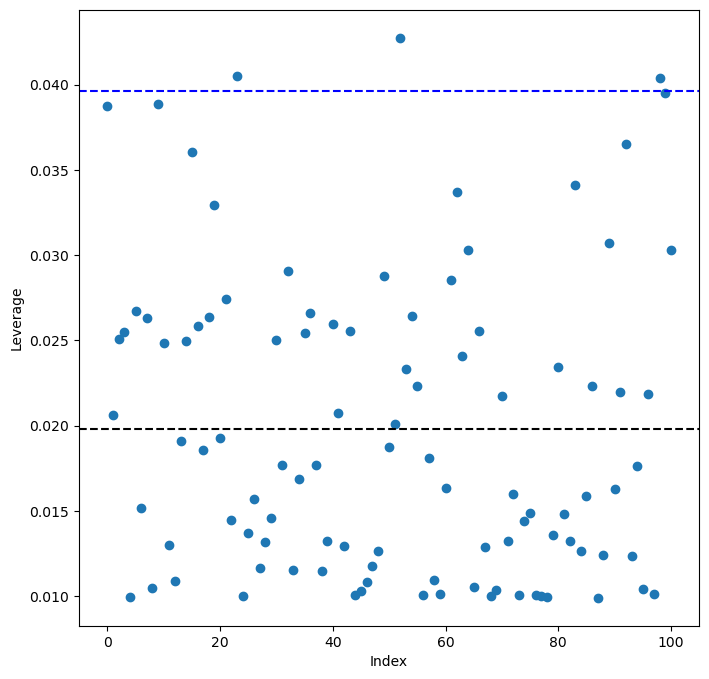

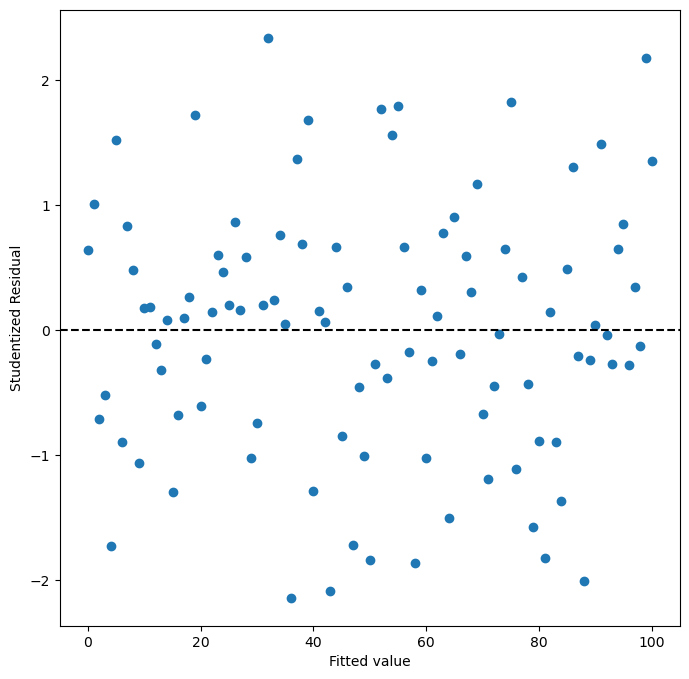

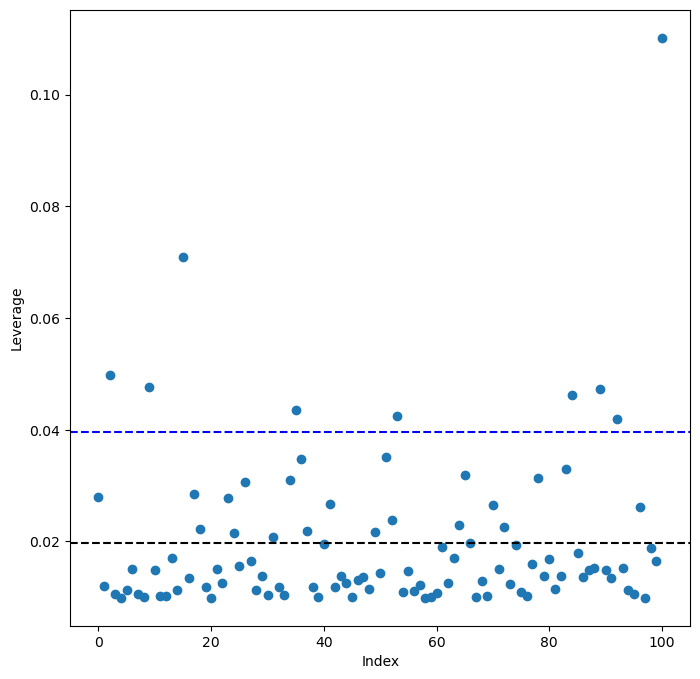

In [43]:
def stud_res_plot(results):
    infl = results.get_influence()
    leverage = infl.hat_matrix_diag
    residuals = results.resid
    mse = np.mean(residuals ** 2)
    studentized_residuals = residuals / np.sqrt(mse * (1 - leverage))

    ax = subplots(figsize=(8,8))[1]
    ax.scatter(est.fittedvalues, studentized_residuals)
    ax.set_xlabel('Fitted value')
    ax.set_ylabel('Studentized Residual')
    ax.axhline(0, c='k', ls='--');

def stud_res_plot2(results,X):
    infl = results.get_influence()
    leverage = infl.hat_matrix_diag
    residuals = results.resid
    mse = np.mean(residuals ** 2)
    studentized_residuals = residuals / np.sqrt(mse * (1 - leverage))

    ax = subplots(figsize=(8,8))[1]
    ax.scatter(np.arange(X.shape[0]), studentized_residuals)
    ax.set_xlabel('Fitted value')
    ax.set_ylabel('Studentized Residual')
    ax.axhline(0, c='k', ls='--');

def leverage_plot(results,X,one):
    infl = results.get_influence()
    ax = subplots(figsize=(8,8))[1]
    ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag)
    ax.set_xlabel('Index')
    ax.set_ylabel('Leverage')
    print(X.shape)
    mean = (X.shape[1] if len(X.shape) > 1 else 1 + one)/X.shape[0]
    threshold = 2 * mean
    ax.axhline(mean, c='k', ls='--');
    ax.axhline(threshold, c='b', ls='--');

    
    
rng = np.random.default_rng (10)
x1 = rng.uniform(0, 1, size =100)
x2 = 0.5 * x1 + rng.normal(size =100) / 10
y = 2 + 2 * x1 + 0.3 * x2 + rng.normal(size =100)

X = np.column_stack((x1, x2))
X = sm.add_constant(X) 

est = sm.OLS(y,X).fit()
print(est.summary())

est = sm.OLS(y,sm.add_constant(x1)).fit()
print(est.summary())

est = sm.OLS(y,sm.add_constant(x2)).fit()
print(est.summary())

x1 = np.concatenate([x1, [0.1]])
x2 = np.concatenate([x2, [0.8]])
y = np.concatenate([y, [6]])

X = np.column_stack((x1, x2))
X = sm.add_constant(X) 

est = sm.OLS(y,X).fit()
print(est.summary())

stud_res_plot2(est,X)
leverage_plot(est,X,0)



est = sm.OLS(y,sm.add_constant(x1)).fit()
print(est.summary())

stud_res_plot2(est,x1)
leverage_plot(est,x1,1)

est = sm.OLS(y,sm.add_constant(x2)).fit()
print(est.summary())

stud_res_plot2(est,x2)
leverage_plot(est,x2,1)



### Answer

---
This  worsened the fit of the x1 simple LRM and improved the fit of the x2 simple LRM
Now the beta2 of the mLRM is signficant and beta1 is not. But again in both sLRM the coefficients are significant.
The added point (0.1,0.8,6) is a high leverage point for the mLRM and specifically for the sLRM(x2) and an outlier for the sLRM(x1).
The new sLRM(x1) is a worse fit now and the new sLRM(x2) is a better fit.



# Exercise 15

This problem involves the Boston data set, which we saw in the lab
for this chapter. We will now try to predict per capita crime rate
using the other variables in this data set. In other words, per capita
crime rate is the response, and the other variables are the predictors.
- For each predictor, fit a simple linear regression model to predict
the response. Describe your results. In which of the models is
there a statistically significant association between the predictor
and the response? Create some plots to back up your assertions.

In [61]:
Boston = load_data('Boston')
Boston
models = {}
def sLRM(x,y):
    print('Simple Linear Regression with predictor: \033[1m' + x.name + '\033[0m')
    xc = sm.add_constant(x)
    est = sm.OLS(y,xc).fit()
    print(est.summary())
    models[x.name] = est

for col in Boston.drop(columns=['crim']):
    sLRM(Boston[col], Boston['crim'])





Simple Linear Regression with predictor: zn
                            OLS Regression Results                            
Dep. Variable:                   crim   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     21.10
Date:                Thu, 20 Feb 2025   Prob (F-statistic):           5.51e-06
Time:                        13:10:09   Log-Likelihood:                -1796.0
No. Observations:                 506   AIC:                             3596.
Df Residuals:                     504   BIC:                             3604.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const   

### Answer 

---
significant association: zn, indus, nox, rm, age, dis, rad,tax, ptratio, lstat, medv
no significant association: chas

C:\Users\Hanna\AppData\Local\Temp\ipykernel_6432\1622191330.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plot(Boston[col], Boston['crim'], models[col].params[0],models[col].params[1], col)


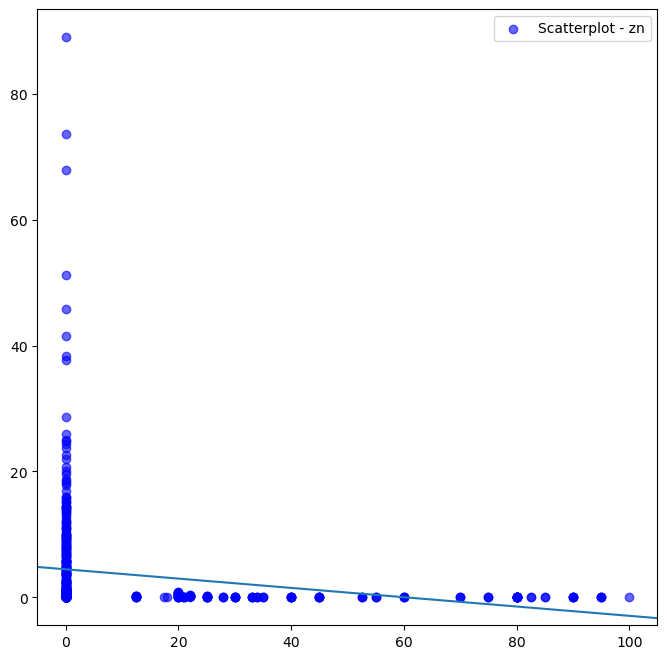

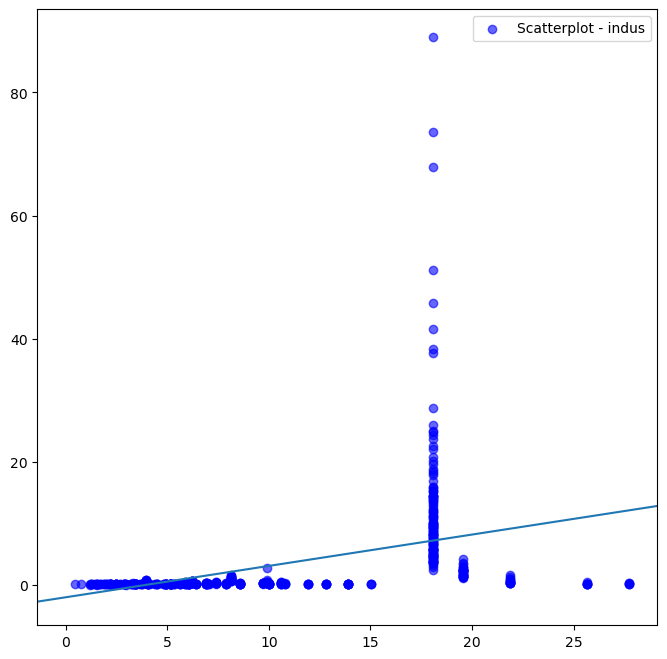

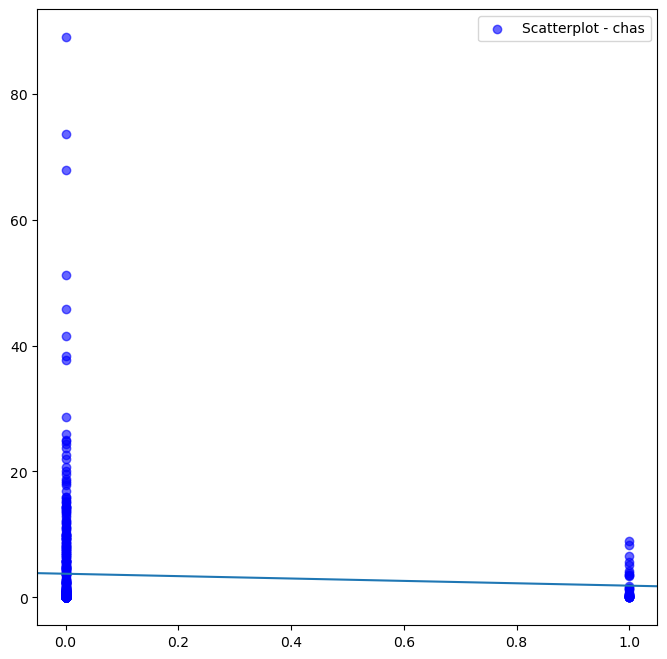

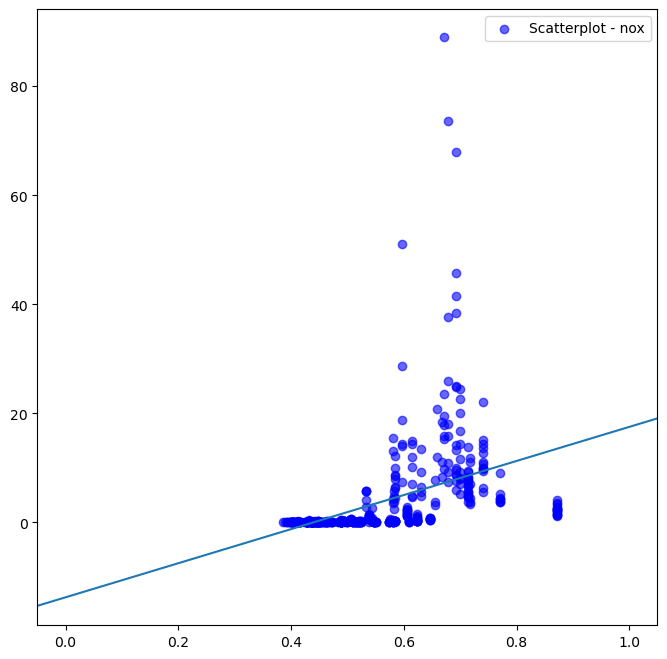

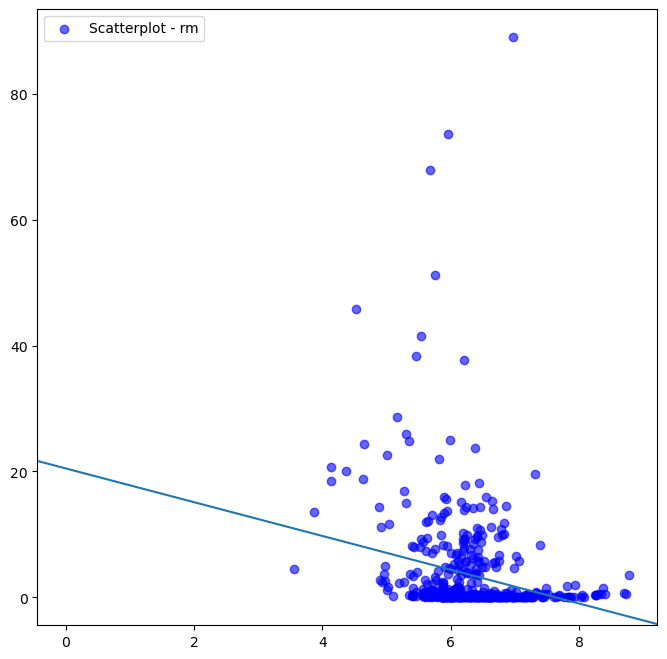

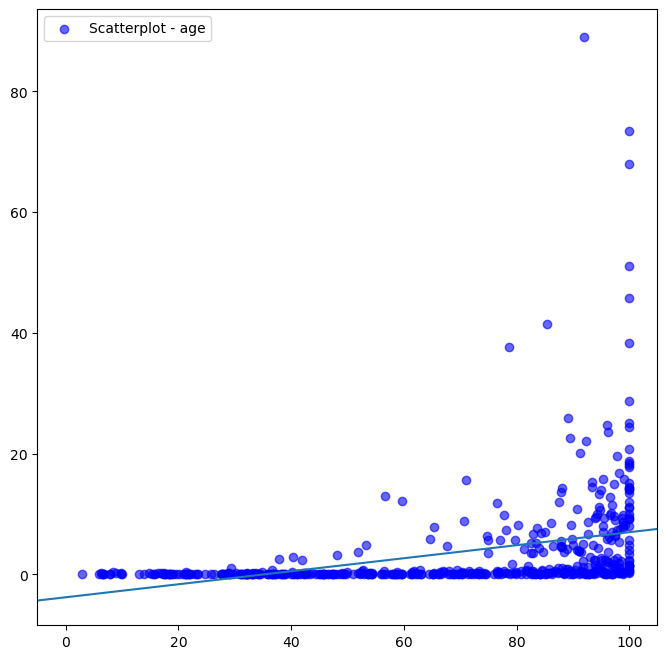

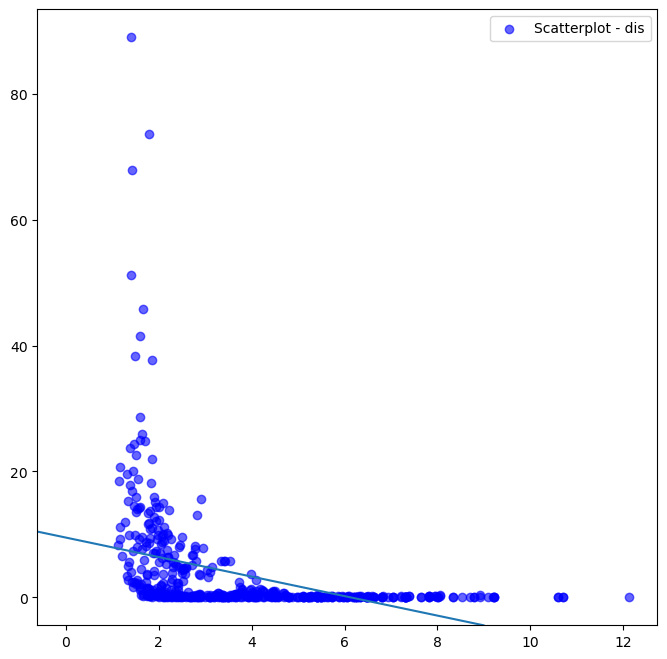

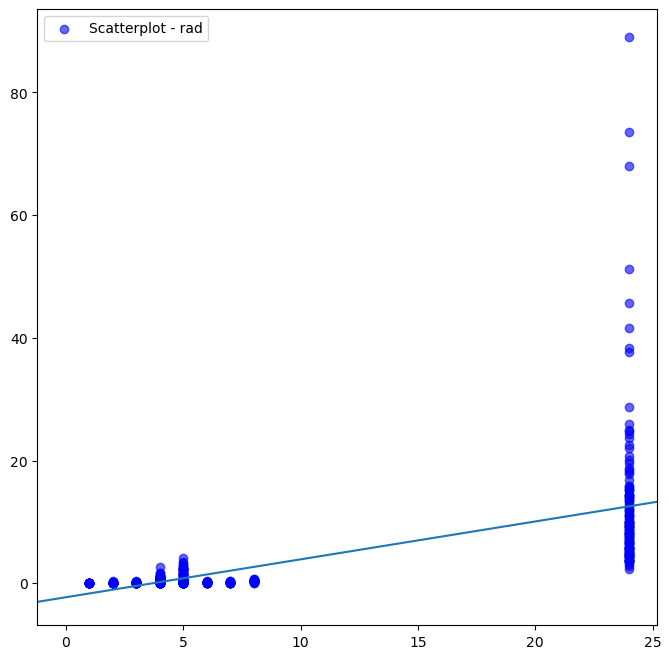

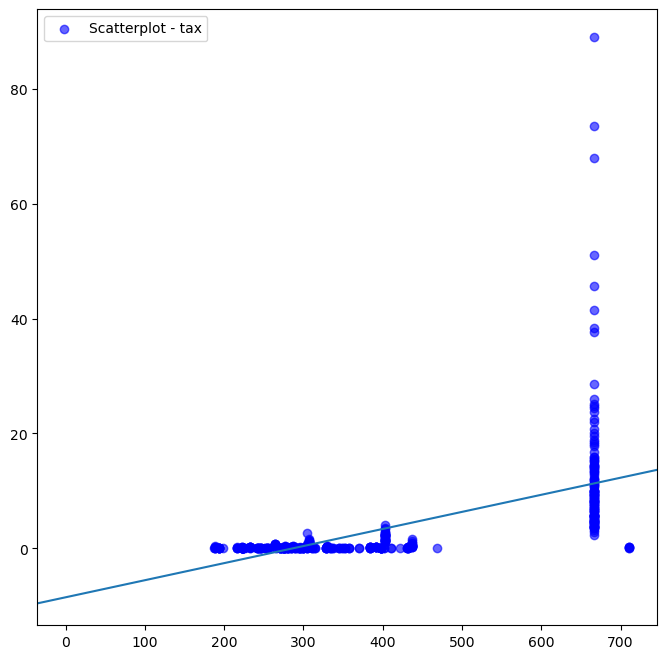

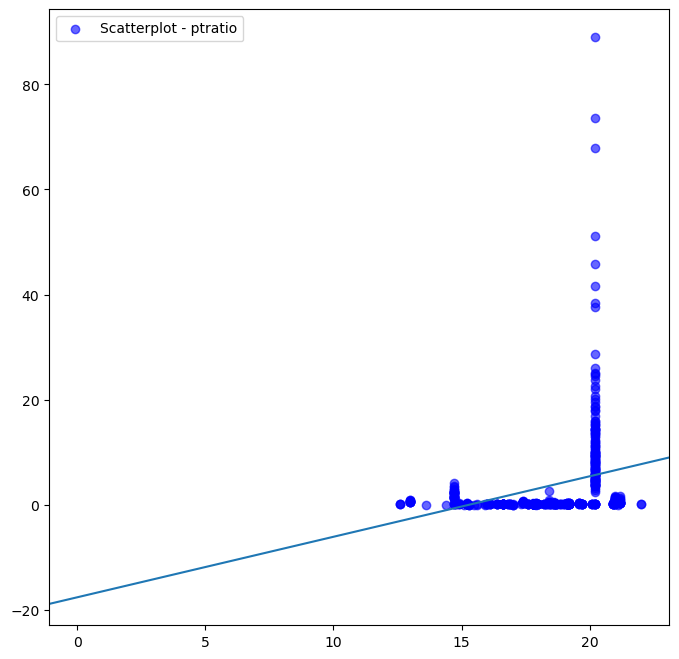

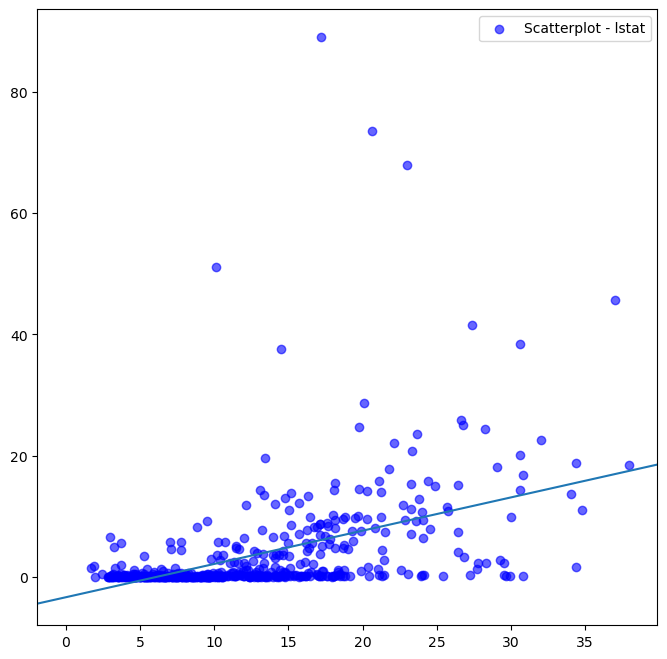

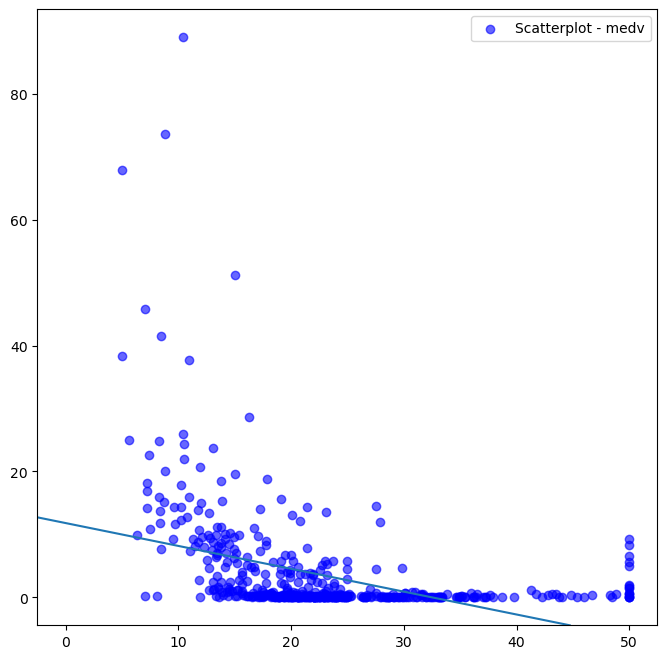

In [64]:
def plot(x,y,b0,b1, col):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(x, y, label="Scatterplot - " + col, color="blue", alpha=0.6)
    ax.axline((0,b0),(1,b0+b1))
    ax.legend()

for col in Boston.drop(columns=['crim']):
    plot(Boston[col], Boston['crim'], models[col].params[0],models[col].params[1], col)



### Task

---
Fit a multiple regression model to predict the response using
all of the predictors. Describe your results. For which predictors
can we reject the null hypothesis H0 : βj = 0?

In [66]:
X = sm.add_constant(Boston.drop(columns=['crim']))
est = sm.OLS(Boston['crim'], X).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   crim   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     33.52
Date:                Thu, 20 Feb 2025   Prob (F-statistic):           2.03e-56
Time:                        13:18:00   Log-Likelihood:                -1655.4
No. Observations:                 506   AIC:                             3337.
Df Residuals:                     493   BIC:                             3392.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.7784      7.082      1.946      0.052      -0.136      27.693
zn             0.0457      0.019      2.433      0.015       0.009       0.083
indus         -0.0584      0.084     -0.698      0.486      -0.223       0.106
chas          -0.8254      1.183     -0.697      0.486      -3.150       1.500
nox           -9.9576      5.290     -1.882      0.060     -20.351       0.436
rm             0.6289      0.607      1.036      0.301      -0.564       1.822
age           -0.0008      0.018     -0.047      0.962      -0.036       0.034
dis           -1.0122      0.282     -3.584      0.000      -1.567      -0.457
rad            0.6125      0.088      6.997      0.000       0.440       0.784
tax           -0.0038      0.005     -0.730      0.466      -0.014       0.006
ptratio       -0.3041      0.186     -1.632      0.103      -0.670       0.062
lstat          0.1388      0.076      1.833      0.067      -0.010       0.288
medv          -0.2201      0.060     -3.678      0.000      -0.338      -0.103
==============================================================================
Omnibus:                      663.436   Durbin-Watson:                   1.516
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            80856.852
Skew:                           6.579   Prob(JB):                         0.00
Kurtosis:                      63.514   Cond. No.                     1.24e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Answer

---

reject H0 for zn, dis, rad,medv
         

### Task

---
- How do your results from the first step compare to your results from the second step?
Create a plot displaying the univariate regression coefficients
from the frist step on the x-axis, and the multiple regression coefficients
from the second step on the y-axis. That is, each predictor is displayed as a
single point in the plot. Its coefficient in a simple linear regression
model is shown on the x-axis, and its coefficient estimate
in the multiple linear regression model is shown on the y-axis.

C:\Users\Hanna\AppData\Local\Temp\ipykernel_6432\3908950099.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x.append(models[col].params[1])
C:\Users\Hanna\AppData\Local\Temp\ipykernel_6432\3908950099.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(est.params[i])


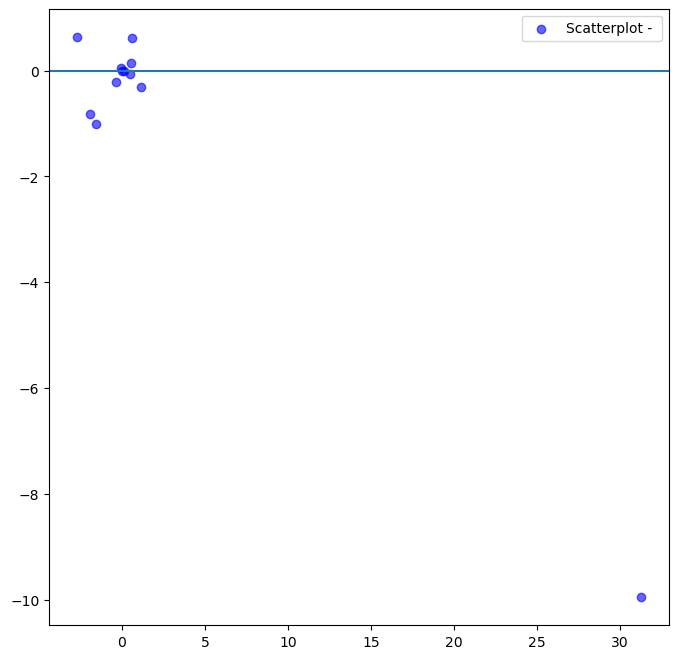

In [68]:
x = []
y = []
i = 1
for col in Boston.drop(columns=['crim']):
    x.append(models[col].params[1])
    y.append(est.params[i])
    i += 1

plot(x,y,0,0,"")

### Task 

---
Is there evidence of non-linear association between any of the
predictors and the response? To answer this question, for each
predictor X, fit a model of the form
Y = β0 + β1X + β2X2 + β3X3 + ϵ.

In [69]:
def sLRM_3poly(x,y):
    print('Simple Linear (polynomial) Regression with predictor: \033[1m' + x.name + '\033[0m')
    x2 = x*x
    x3 = x2 * x
    xc = pd.DataFrame({x.name:x, x.name + ' ** 2': x2, x.name + ' ** 3': x3})
    xc = sm.add_constant(xc)
    est = sm.OLS(y,xc).fit()
    print(est.summary())
    models[x.name] = est

for col in Boston.drop(columns=['crim']):
    sLRM_3poly(Boston[col], Boston['crim'])

Simple Linear (polynomial) Regression with predictor: zn
                            OLS Regression Results                            
Dep. Variable:                   crim   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     10.35
Date:                Thu, 20 Feb 2025   Prob (F-statistic):           1.28e-06
Time:                        13:34:34   Log-Likelihood:                -1791.2
No. Observations:                 506   AIC:                             3590.
Df Residuals:                     502   BIC:                             3607.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------